In [1]:
from salford_datasets.salford import SalfordData, SalfordFeatures
from acd_experiment.sci import SCIData, SCICols
from acd_experiment.salford_adapter import SalfordAdapter

from aif360.sklearn.metrics import generalized_entropy_error, between_group_generalized_entropy_error
from sklearn.metrics import confusion_matrix, precision_score, recall_score


import torch
import numpy as np
import pandas as pd

import os

import matplotlib.pyplot as plt
import seaborn as sns

from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer, pipeline
from transformers.pipelines.pt_utils import KeyDataset
from datasets import Dataset
import evaluate

from tqdm.auto import tqdm

sns.set(style='white', palette='colorblind', rc={'figure.dpi': 150, 'savefig.dpi': 150})

2023-08-22 10:38:28.689374: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def get_tabular_dataset(select_features, outcome, dataset, triage_note=True):
    # Get the columns to keep
    scores_with_notes_labs_and_hospital = ['Obs_RespiratoryRate_Admission', 'Obs_BreathingDevice_Admission',
                                           'Obs_O2Sats_Admission', 'Obs_Temperature_Admission',
                                           'Obs_SystolicBP_Admission', 'Obs_DiastolicBP_Admission',
                                           'Obs_HeartRate_Admission', 'Obs_AVCPU_Admission',
                                           'Obs_Pain_Admission', 'Obs_Nausea_Admission', 'Obs_Vomiting_Admission',
                                           'Female', 'Age', 'Blood_Haemoglobin_Admission', 'Blood_Urea_Admission',
                                           'Blood_Sodium_Admission', 'Blood_Potassium_Admission',
                                           'Blood_Creatinine_Admission', 'AE_PresentingComplaint',
                                           'AE_MainDiagnosis', 'SentToSDEC', 'Readmission', 'AdmitMethod',
                                           'AdmissionSpecialty']
    new_features = ['Blood_DDimer_Admission', 'Blood_CRP_Admission', 'Blood_Albumin_Admission',
                    'Blood_WhiteCount_Admission', 'Waterlow_Score', 'CFS_Score', 'CharlsonIndex']

    if select_features == 'sci':
        columns = scores_with_notes_labs_and_hospital
    elif select_features == 'sci_no_adm':
        columns = scores_with_notes_labs_and_hospital[:-1]
    elif select_features == 'new':
        columns = scores_with_notes_labs_and_hospital + new_features
    elif select_features == 'new_no_adm':
        columns = scores_with_notes_labs_and_hospital[:-1] + new_features
    elif select_features == 'new_triagenotes':
        columns = scores_with_notes_labs_and_hospital + new_features
    elif select_features == 'sci_triagenotes':
        columns = scores_with_notes_labs_and_hospital
    elif select_features == 'new_diag':
        columns = scores_with_notes_labs_and_hospital + new_features + SalfordFeatures.Diagnoses
        dataset = dataset.expand_icd10_definitions()
    else:
        columns = None

    # Derive the required CriticalEvent
    if outcome == 'strict':
        dataset = dataset.derive_critical_event(wards=["CCU"], ignore_admit_ward=True)
    elif outcome == 'h1':
        dataset = dataset.derive_critical_event(wards=["CCU", "HH1M"], ignore_admit_ward=True)
    elif outcome == 'direct':
        dataset = dataset.derive_critical_event(wards=["CCU"], ignore_admit_ward=False)
    elif outcome in ['Readmitted', 'ReadmittedPneumonia']:
        pass
    else:
        dataset = dataset.derive_critical_event(wards=["CCU", "HH1M"], ignore_admit_ward=False)

    if triage_note:
        # Separate TriageNote from tabular data with [SEP], then commas for tabular columns
        text_series = dataset.to_text(['AE_TriageNote'], column_name=True, inplace=False)['text']
        dataset_tab_text = dataset.to_text(columns, column_name=True, sep_token=', ')
        dataset_tab_text['text'] = text_series + dataset_tab_text['text']
    else:
        dataset_tab_text = dataset.to_text(columns=columns, column_name=True, sep_token=', ')

    # Convert to HF dataset
    encoded_dataset = Dataset.from_pandas(dataset_tab_text)
    encoded_dataset = encoded_dataset.remove_columns('SpellSerial')
    encoded_dataset = encoded_dataset.class_encode_column('label')

    return encoded_dataset

In [27]:
dataset = SalfordData.from_raw(pd.read_hdf('/media/hdd/nihr-data/SalfordNew/raw_v2.h5', key='table'))
dataset = dataset.augment_derive_all()
dataset = dataset.inclusion_exclusion_criteria()

dataset = SalfordData(dataset[dataset['AdmissionDate'] >= pd.to_datetime('2020-02-01')])

In [28]:
dataset = SalfordData(dataset.dropna(subset=['NEWS_Score_Admission', 'CriticalEvent']))

In [29]:
# For testing
#dataset = SalfordData(dataset.sample(n=100))

In [30]:
# Get the text-only dataset
DEMOGRAPHICS = True
TARGET = "CriticalEvent"
num_labels = 2

if TARGET == "ReadmissionBand":
    dataset = SalfordData(dataset.derive_readmission_band())
    original_readm_col = dataset['ReadmissionBand']
    dataset['ReadmissionBand'] = dataset['ReadmissionBand'].cat.codes

if DEMOGRAPHICS:
    text_series = dataset.to_text(['AE_TriageNote'], column_name=True, inplace=False)['text']
    dataset_text = dataset.to_text(SalfordFeatures.Demographics, column_name=True, target_col=TARGET, sep_token=', ')
    dataset_text['text'] = text_series + dataset_text['text']
else:
    columns = ['AE_TriageNote', 'AE_PresentingComplaint']

    dataset_text = dataset.to_text(columns=columns, target_col=TARGET, column_name=True, sep_token=', ')

# Convert to HF dataset
encoded_dataset = Dataset.from_pandas(dataset_text)
encoded_dataset = encoded_dataset.remove_columns('SpellSerial')
encoded_dataset = encoded_dataset.class_encode_column('label')

dataset_text_eval = encoded_dataset
#dataset_text_eval = encoded_dataset.train_test_split(test_size=0.2, shuffle=True, stratify_by_column='label')['test']

Stringifying the column:   0%|          | 0/10000 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [31]:
# how many patients are healthy vs. unhealthy
num_sick = np.sum(dataset['CriticalEvent'])
num_healthy = len(dataset) - num_sick

N = num_healthy + num_sick
prevalance = num_sick / N

print(f"N: {N}, prevalance: {prevalance}")

N: 10000, prevalance: 0.0228


In [32]:
# Get NEWS score for test patients, normalise to get a 'probability'
news_proba = dataset['NEWS_Score_Admission'] / (dataset['NEWS_Score_Admission'].max() - dataset['NEWS_Score_Admission'].min())

In [33]:
basepath = '/home/matthew/phd/acute-care-pathways/runs/'

# These are the model setups
models = {
    'Triage Data': ['triageNotes-critevent/emilyalsentzer/Bio_ClinicalBERT-finetuned-salford-textonly-triage/',
                    encoded_dataset],
    'Core Tabular': ['nlp/newData/featuressci-outcomesci/emilyalsentzer/Bio_ClinicalBERT-finetuned-salford-alltext/',
                get_tabular_dataset('sci', 'CriticalEvent', dataset, True)],
    'Extended Tabular': ['nlp/newData/featuresnew-outcomesci/emilyalsentzer/Bio_ClinicalBERT-finetuned-salford-alltext/',
                get_tabular_dataset('new', 'CriticalEvent', dataset, True)],
    'Core Tabular + Triage Data': ['nlp/sci_triagenotes-sci-columnnames/emilyalsentzer/Bio_ClinicalBERT-finetuned-salford-alltext/',
                          get_tabular_dataset('sci_triagenotes', 'CriticalEvent', dataset, True)],
    'Extended Tabular + Triage Data': ['nlp/featuresnewTriage-outcomeci-columnnames/emilyalsentzer/Bio_ClinicalBERT-finetuned-salford-alltext/',
                                   get_tabular_dataset('new_triagenotes', 'CriticalEvent', dataset, True)]
}

Stringifying the column:   0%|          | 0/10000 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/10000 [00:00<?, ? examples/s]

Stringifying the column:   0%|          | 0/10000 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/10000 [00:00<?, ? examples/s]

Stringifying the column:   0%|          | 0/10000 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/10000 [00:00<?, ? examples/s]

Stringifying the column:   0%|          | 0/10000 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [34]:
all_pred_labels = {}
all_pred_proba = {}

for model_name in models:
    model_path = os.path.join(basepath, models[model_name][0])
    tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=True, device=0)
    model = AutoModelForSequenceClassification.from_pretrained(model_path, output_hidden_states=False,
                                                               num_labels=num_labels, ignore_mismatched_sizes=True)
    
    clf_pipe = pipeline('text-classification', model=model, tokenizer=tokenizer, device=0, max_length=512, 
                    truncation=True)
    pred_labels = []
    pred_proba = []
    
    for out in tqdm(clf_pipe(KeyDataset(models[model_name][1], "text"), batch_size=32), 
                total=len(models[model_name][1])):
        pred_labels.append(int(out['label'][-1]))

        # If output label is 0, get the opposite score for binary-classification like eval
        if int(out['label'][-1]) == 0:
            pred_proba.append(1 - out['score'])
        else:
            pred_proba.append(out['score'])
    
    all_pred_labels[model_name] = pred_labels
    all_pred_proba[model_name] = pred_proba

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [35]:
# Get net benefit at different thresholds
p_thresh = np.linspace(0, 1, 100, endpoint=False)

model_benefit = {model: [] for model in models}
news_benefit = []
treat_all_y = []

for p_t in p_thresh:
    # Is the predicted probability of class 1 larger than the current threshold?
    for model in models:
        pred = all_pred_proba[model] > p_t

        tn, fp, fn, tp = confusion_matrix(dataset['CriticalEvent'], pred).ravel()
        net_ben = (tp / N) - (fp / N) * (p_t / (1 - p_t))
        model_benefit[model].append(net_ben)
    
    # How many patients are classified as at risk by NEWS at this probability?
    news_pred = news_proba > p_t
    tn, fp, fn, tp = confusion_matrix(dataset['CriticalEvent'], news_pred).ravel()
    news_net_ben = (tp / N) - (fp / N) * (p_t / (1 - p_t))
    news_benefit.append(news_net_ben)
    
    treat_all_net_ben = (num_sick / N) - (num_healthy / N) * (p_t / (1 - p_t))
    treat_all_y.append(treat_all_net_ben)

In [36]:
treat_none_y = [0 for _ in p_thresh]

rows = []
for i in range(len(p_thresh)):
    for model in models:
        rows.append([p_thresh[i], model_benefit[model][i], model])
        
    rows.append([p_thresh[i], news_benefit[i], 'NEWS'])
    rows.append([p_thresh[i], treat_none_y[i], 'treat none'])
    rows.append([p_thresh[i], treat_all_y[i], 'treat all'])
decision_curve_df = pd.DataFrame(rows, columns=['p_thresh', 'net_benefit', 'model'])

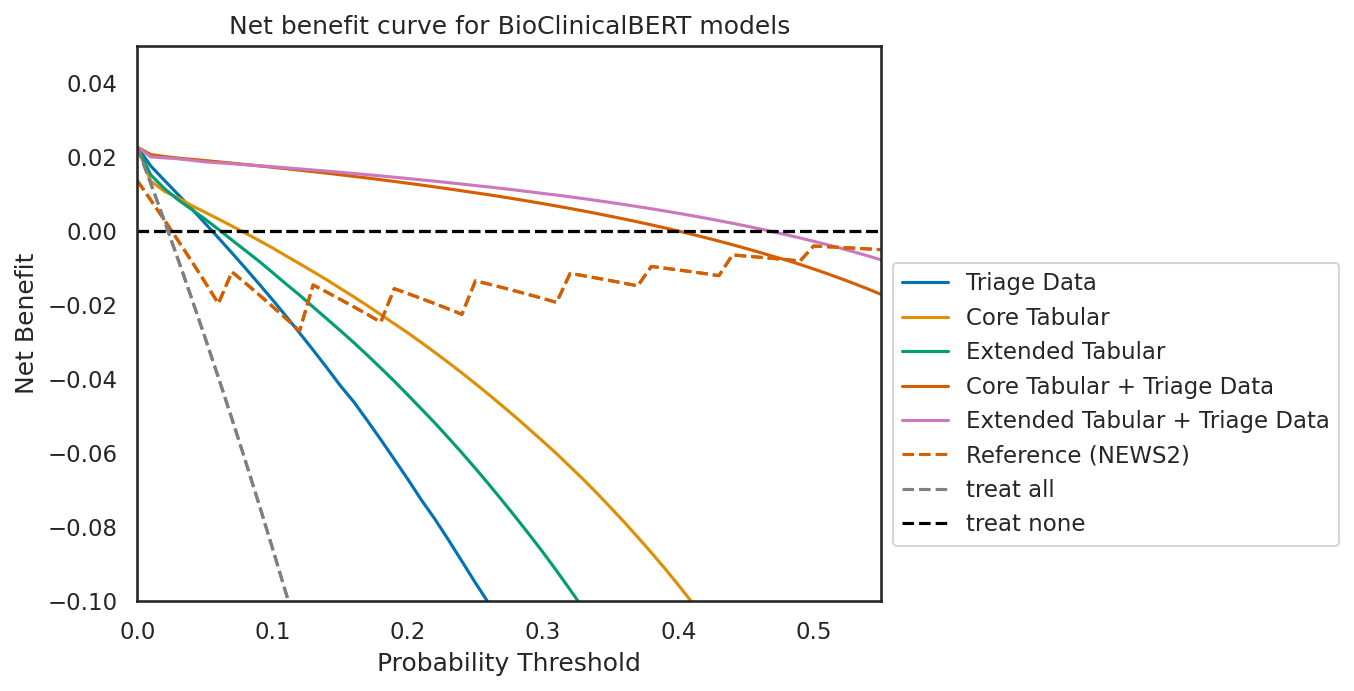

In [37]:
g = sns.lineplot(data=decision_curve_df[~decision_curve_df['model'].isin(['NEWS', 'treat all', 'treat none'])],
                                                                         x='p_thresh', y='net_benefit', hue='model')
g.set(xlim=[0, 0.55], ylim=[-0.1, 0.05])
plt.title('Net benefit curve for BioClinicalBERT models')
plt.xlabel('Probability Threshold')
plt.ylabel('Net Benefit')


# Manually add NEWS so we can set its style
x = decision_curve_df.loc[decision_curve_df['model'] == 'NEWS', 'p_thresh']
y = decision_curve_df.loc[decision_curve_df['model'] == 'NEWS', 'net_benefit']
g.plot(x, y, linestyle='--', color='r')

# Add NEWS to legend
handles, labels = g.get_legend_handles_labels()
handles.append(g.plot(x, y, linestyle='--', color='r')[0])
labels.append("Reference (NEWS2)")

# Manually add baselines so we can set its style
x = decision_curve_df.loc[decision_curve_df['model'] == 'treat all', 'p_thresh']
y = decision_curve_df.loc[decision_curve_df['model'] == 'treat all', 'net_benefit']
g.plot(x, y, linestyle='--', color='gray')

# Add baselines to legend
#handles, labels = g.get_legend_handles_labels()
handles.append(g.plot(x, y, linestyle='--', color='gray')[0])
labels.append("treat all")

x = decision_curve_df.loc[decision_curve_df['model'] == 'treat none', 'p_thresh']
y = decision_curve_df.loc[decision_curve_df['model'] == 'treat none', 'net_benefit']
g.plot(x, y, linestyle='--', color='black')

# Add baselines to legend
#handles, labels = g.get_legend_handles_labels()
handles.append(g.plot(x, y, linestyle='--', color='black')[0])
labels.append("treat none")


plt.legend(handles=handles, labels=labels, bbox_to_anchor=(1, 0.63))